# TensorFlow script mode training and serving
###  Modified From: 
#### Sagemaker Python SDK Examples: tensorflow_script_mode_training_and_serving.ipynb
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb

Following modifications were made:  
1. Incorporated scripts for local mode hosting  
2. Added Train and Test Channels  
3. Visualize results (confusion matrix and reports)  
4. Added steps to deploy using model artifacts stored in S3  
5. Iris model training

Script mode is a training script format for TensorFlow that lets you execute any TensorFlow training script in SageMaker with minimal modification. The [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) handles transferring your script to a SageMaker training instance. On the training instance, SageMaker's native TensorFlow support sets up training-related environment variables and executes your training script. In this tutorial, we use the SageMaker Python SDK to launch a training job and deploy the trained model.

Script mode supports training with a Python script, a Python module, or a shell script.


# Set up the environment

Let's start by setting up the environment:

### Local Mode Execution - requires docker compose configured
#### The below setup script is from AWS SageMaker Python SDK Examples : tf-eager-sm-scriptmode.ipynb

In [4]:
!/bin/bash ./setup.sh

SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [5]:
import os
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

## Training Data

In [6]:
column_list_file = 'iris_train_column_list.txt'
train_file = 'iris_train.csv'
test_file = 'iris_validation.csv'

columns = ''
with open(column_list_file,'r') as f:
    columns = f.read().split(',')

In [7]:
# Specify your bucket name
bucket_name = 'jd-ml-sagemaker-1'

training_folder = r'iris/train'
test_folder = r'iris/test'
model_folder = r'iris/model/'

training_data_uri = r's3://' + bucket_name + r'/' + training_folder
testing_data_uri = r's3://' + bucket_name + r'/' + test_folder
model_data_uri = r's3://' + bucket_name + r'/' + model_folder

In [8]:
training_data_uri,testing_data_uri,model_data_uri

('s3://jd-ml-sagemaker-1/iris/train',
 's3://jd-ml-sagemaker-1/iris/test',
 's3://jd-ml-sagemaker-1/iris/model/')

In [9]:
sagemaker_session.upload_data(train_file,
                              bucket=bucket_name, 
                              key_prefix=training_folder)

's3://jd-ml-sagemaker-1/iris/train/iris_train.csv'

In [10]:
sagemaker_session.upload_data(test_file, 
                              bucket=bucket_name, 
                              key_prefix=test_folder)

's3://jd-ml-sagemaker-1/iris/test/iris_validation.csv'

# Construct a script for distributed training

This tutorial's training script was adapted from TensorFlow's official [CNN MNIST example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py). We have modified it to handle the ``model_dir`` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

At the end of the training job we have added a step to export the trained model to the path stored in the environment variable ``SM_MODEL_DIR``, which always points to ``/opt/ml/model``. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

Here is the entire script:

In [11]:
!pygmentize 'tensorflow_iris.py'

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.import tensorflow as tf

# Modified to train Iris model with early stopping - CL

import os
import numpy as np
import json
import pandas as pd
# Set random seed
np.random.seed(0)

import tensorflow as tf
import argparse


def model(x_train, y_train, x_test, y_test):
    model = tf.keras.models.Sequential()    
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu, input_dim=x_train.shape[1]))
    model.add(tf.keras.layers.De

# Create a training job using the `TensorFlow` estimator

The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container, uploading your script to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

* `py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting `py_version` to `'py2'` and `script_mode` to `True`.

* `distributions` is used to configure the distributed training setup. It's required only if you are doing distributed training either across a cluster of instances or across multiple GPUs. Here we are using parameter servers as the distributed training schema. SageMaker training jobs run on homogeneous clusters. To make parameter server more performant in the SageMaker setup, we run a parameter server on every instance in the cluster, so there is no need to specify the number of parameter servers to launch. Script mode also supports distributed training with [Horovod](https://github.com/horovod/horovod). You can find the full documentation on how to configure `distributions` [here](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow#distributed-training). 



In [12]:
from sagemaker.tensorflow import TensorFlow

You can also initiate an estimator to train with TensorFlow 2.1 script. The only things that you will need to change are the script name and ``framewotk_version``

In [13]:
#instance_type='ml.m5.xlarge'
instance_type='local'

In [14]:
estimator = TensorFlow(entry_point='tensorflow_iris.py',
                       role=role,
                       train_instance_count=1,
                       train_instance_type=instance_type,
                       framework_version='2.1.0',
                       py_version='py3',
                       output_path=model_data_uri,
                       base_job_name='tf-iris',                       
                       distributions={'parameter_server': {'enabled': False}})

## Calling ``fit``

To start a training job, we call `estimator.fit(training_data_uri)`.

An S3 location is used here as the input. `fit` creates a default channel named `'training'`, which points to this S3 location. In the training script we can then access the training data from the location stored in `SM_CHANNEL_TRAINING`. `fit` accepts a couple other types of input as well. See the API doc [here](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) for details.

When training starts, the TensorFlow container executes mnist.py, passing `hyperparameters` and `model_dir` from the estimator as script arguments. Because we didn't define either in this example, no hyperparameters are passed, and `model_dir` defaults to `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`, so the script execution is as follows:
```bash
python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>
```
When training is complete, the training job will upload the saved model for TensorFlow serving.

Calling fit to train a model with TensorFlow 2.1 scroipt.

In [15]:
estimator.fit({'training':training_data_uri,'testing':testing_data_uri})

Creating tmpc607vy47_algo-1-gr2t2_1 ... 
Attaching to tmpc607vy47_algo-1-gr2t2_12mdone
algo-1-gr2t2_1  | 2020-07-03 02:14:02,492 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-gr2t2_1  | 2020-07-03 02:14:02,498 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-gr2t2_1  | 2020-07-03 02:14:02,674 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-gr2t2_1  | 2020-07-03 02:14:02,688 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-gr2t2_1  | 2020-07-03 02:14:02,703 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-gr2t2_1  | 2020-07-03 02:14:02,713 sagemaker-containers INFO     Invoking user script
algo-1-gr2t2_1  | 
algo-1-gr2t2_1  | Training Env:
algo-1-gr2t2_1  | 
algo-1-gr2t2_1  | {
algo-1-gr2t2_1  |     "additional_framework_parameters": {
algo-1-gr2t2_1  |         "sagemaker_parameter_server_enabled": 

In [16]:
estimator.latest_training_job.job_name

'tf-iris-2020-07-03-02-13-03-430'

In [17]:
estimator.model_data

's3://jd-ml-sagemaker-1/iris/model/tf-iris-2020-07-03-02-13-03-430/model.tar.gz'

# Deploy the trained model to an endpoint

The `deploy()` method creates a SageMaker model, which is then deployed to an endpoint to serve prediction requests in real time. We will use the TensorFlow Serving container for the endpoint, because we trained with script mode. This serving container runs an implementation of a web server that is compatible with SageMaker hosting protocol. The [Using your own inference code]() document explains how SageMaker runs inference containers.

Deployed the trained TensorFlow 2.1 model to an endpoint.

In [18]:
predictor = estimator.deploy(initial_instance_count=1, instance_type=instance_type)

Attaching to tmp3b8lhuif_algo-1-3ufpa_1
algo-1-3ufpa_1  | INFO:__main__:starting services
algo-1-3ufpa_1  | INFO:__main__:using default model name: model
algo-1-3ufpa_1  | INFO:__main__:tensorflow serving model config: 
algo-1-3ufpa_1  | model_config_list: {
algo-1-3ufpa_1  |   config: {
algo-1-3ufpa_1  |     name: "model",
algo-1-3ufpa_1  |     base_path: "/opt/ml/model",
algo-1-3ufpa_1  |     model_platform: "tensorflow"
algo-1-3ufpa_1  |   }
algo-1-3ufpa_1  | }
algo-1-3ufpa_1  | 
algo-1-3ufpa_1  | 
algo-1-3ufpa_1  | INFO:__main__:nginx config: 
algo-1-3ufpa_1  | load_module modules/ngx_http_js_module.so;
algo-1-3ufpa_1  | 
algo-1-3ufpa_1  | worker_processes auto;
algo-1-3ufpa_1  | daemon off;
algo-1-3ufpa_1  | pid /tmp/nginx.pid;
algo-1-3ufpa_1  | error_log  /dev/stderr info;
algo-1-3ufpa_1  | 
algo-1-3ufpa_1  | worker_rlimit_nofile 4096;
algo-1-3ufpa_1  | 
algo-1-3ufpa_1  | events {
algo-1-3ufpa_1  |   worker_connections 2048;
algo-1-3ufpa_1  | }
algo-1-3ufpa_1  | 
algo-1-3ufpa_1  

# Invoke the endpoint

Let's download the training data and use that as input for inference.

Examine the prediction result from the TensorFlow 2.1 model.

In [27]:
df = pd.read_csv(test_file, names=columns)

In [28]:
df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width
0,1,5.8,2.7,4.1,1.0
1,0,4.8,3.4,1.6,0.2
2,1,6.0,2.2,4.0,1.0
3,2,6.4,3.1,5.5,1.8
4,2,6.7,2.5,5.8,1.8


In [29]:
X_test = df.iloc[:,1:].values
print(X_test[:5])

[[5.8 2.7 4.1 1. ]
 [4.8 3.4 1.6 0.2]
 [6.  2.2 4.  1. ]
 [6.4 3.1 5.5 1.8]
 [6.7 2.5 5.8 1.8]]


In [30]:
result = predictor.predict(X_test)

algo-1-3ufpa_1  | 172.18.0.1 - - [03/Jul/2020:02:17:00 +0000] "POST /invocations HTTP/1.1" 200 1913 "-" "-"


In [31]:
result =  result['predictions']

In [32]:
result[:5]

[[0.0735502243, 0.607454956, 0.318994761],
 [0.884951, 0.102730215, 0.01231879],
 [0.0650803298, 0.62181896, 0.313100666],
 [0.00703936862, 0.481133968, 0.511826694],
 [0.00328026386, 0.443580389, 0.553139329]]

In [33]:
df['predicted_class'] = np.argmax(result,axis=1)

In [34]:
df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width,predicted_class
0,1,5.8,2.7,4.1,1.0,1
1,0,4.8,3.4,1.6,0.2,0
2,1,6.0,2.2,4.0,1.0,1
3,2,6.4,3.1,5.5,1.8,2
4,2,6.7,2.5,5.8,1.8,2


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [36]:
# Encode Class Labels to integers
# Labeled Classes
labels=[0,1,2]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

<h2>Confusion Matrix</h2>
Confusion Matrix is a table that summarizes performance of classification model.<br><br>

In [37]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [38]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['encoded_class'],
                              df['predicted_class'],labels=labels)

In [39]:
cnf_matrix

array([[16,  0,  0],
       [ 0, 10,  1],
       [ 0,  4, 14]])

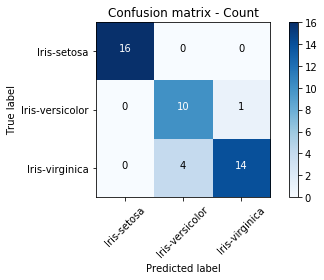

In [40]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count')

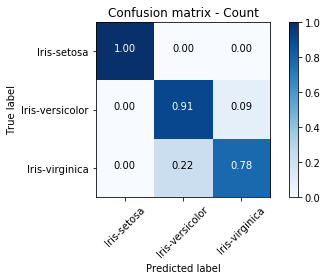

In [41]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count',normalize=True)

In [42]:
print(classification_report(
    df['encoded_class'],
    df['predicted_class'],
    labels=labels,
    target_names=classes))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       0.71      0.91      0.80        11
 Iris-virginica       0.93      0.78      0.85        18

       accuracy                           0.89        45
      macro avg       0.88      0.90      0.88        45
   weighted avg       0.90      0.89      0.89        45



# Delete the endpoint

Let's delete the endpoint we just created to prevent incurring any extra costs.

Delete the TensorFlow 2.1 endpoint as well.

In [43]:
estimator.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


# Deploy model using artifacts
https://sagemaker.readthedocs.io/en/stable/using_tf.html#deploy-to-a-sagemaker-endpoint

In [44]:
from sagemaker.tensorflow.serving import Model

In [45]:
model_data = estimator.model_data

In [46]:
model_data

's3://jd-ml-sagemaker-1/iris/model/tf-iris-2020-07-03-02-13-03-430/model.tar.gz'

In [47]:
model = Model(model_data=model_data, role=role,framework_version='2.1.0')
predictor = model.deploy(initial_instance_count=1, instance_type=instance_type)

Attaching to tmpmmx_h52y_algo-1-kb5us_1
algo-1-kb5us_1  | INFO:__main__:starting services
algo-1-kb5us_1  | INFO:__main__:using default model name: model
algo-1-kb5us_1  | INFO:__main__:tensorflow serving model config: 
algo-1-kb5us_1  | model_config_list: {
algo-1-kb5us_1  |   config: {
algo-1-kb5us_1  |     name: "model",
algo-1-kb5us_1  |     base_path: "/opt/ml/model",
algo-1-kb5us_1  |     model_platform: "tensorflow"
algo-1-kb5us_1  |   }
algo-1-kb5us_1  | }
algo-1-kb5us_1  | 
algo-1-kb5us_1  | 
algo-1-kb5us_1  | INFO:__main__:nginx config: 
algo-1-kb5us_1  | load_module modules/ngx_http_js_module.so;
algo-1-kb5us_1  | 
algo-1-kb5us_1  | worker_processes auto;
algo-1-kb5us_1  | daemon off;
algo-1-kb5us_1  | pid /tmp/nginx.pid;
algo-1-kb5us_1  | error_log  /dev/stderr error;
algo-1-kb5us_1  | 
algo-1-kb5us_1  | worker_rlimit_nofile 4096;
algo-1-kb5us_1  | 
algo-1-kb5us_1  | events {
algo-1-kb5us_1  |   worker_connections 2048;
algo-1-kb5us_1  | }
algo-1-kb5us_1  | 
algo-1-kb5us_1 

In [48]:
X_test[:5]

array([[5.8, 2.7, 4.1, 1. ],
       [4.8, 3.4, 1.6, 0.2],
       [6. , 2.2, 4. , 1. ],
       [6.4, 3.1, 5.5, 1.8],
       [6.7, 2.5, 5.8, 1.8]])

In [49]:
predictor.predict(X_test[:5])

{'predictions': [[0.0735502243, 0.607454956, 0.318994761],
  [0.884951, 0.102730215, 0.01231879],
  [0.0650803298, 0.62181896, 0.313100666],
  [0.00703936862, 0.481133968, 0.511826694],
  [0.00328026386, 0.443580389, 0.553139329]]}

algo-1-kb5us_1  | 172.18.0.1 - - [03/Jul/2020:02:17:59 +0000] "POST /invocations HTTP/1.1" 200 234 "-" "-"


In [50]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
